# Classification Project: What Causes Telco Churn?

## --- Pipeline phase 1: Planning: ---

 ### In this notebook we will explore where drivers for churn or attrition might be based on a dataset snapshot of customers for a telecommunications service.  We will investigate differences between groups of customers and what might make one group or class different from another, and if that has any bearing on their propensity to leave the company.
 
 ### Please reference data_dictionary.py for explicit details on features.

In [1]:
# setting up our environment: 

import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from acquire import get_telco_data
from prepare import *
from data_dictionary import datadict
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter


from scipy.stats import ttest_ind as ttest
from scipy.stats import pearsonr

import graphviz
from graphviz import Graph

In [2]:
datadict()

 Data Dictionary:
    customer_id:
        The identification number of any client in the telco dataset.
    gender:
        The identified gender of any customer in the telco dataset.
        listed in english as 'Male' or 'Female.'
    senior_citizen:
        The status of a customer as a senior citizen in binary value.
        0: Not a senior
        1: senior citizen.
    partner:
        Status of whether or not a customer has a domestic partner.
        listed in Yes/No values.
    dependents:
        Status of whether or not a customer has dependents.
        listed in Yes/No values.
    tenure:
        How long the customer has been with the company in months
    phone_service:
        Status of whether or not the customer has phone service
        Yes/No values
    multiple_lines:
        Status of whether or not customer has multiple phone lines.
        Lists 'no phone service' if phone_service value is 'No'
    internet_service_type:
        Indication of what type of inter

## --- Pipeline phase 2: Acquisition: ---

In [3]:
# call our function to pull our dataframe using mySQL:
df = get_telco_data()

In [4]:
# get info on dataframe 
peekatdata(df)

  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0003-MKNFE    Male               0      No         No       9   
1  0013-MHZWF  Female               0      No        Yes       9   
2  0015-UOCOJ  Female               1      No         No       7   
3  0023-HGHWL    Male               1      No         No       1   
4  0032-PGELS  Female               0     Yes        Yes       1   

  phone_service    multiple_lines  internet_service_type_id online_security  \
0           Yes               Yes                         1              No   
1           Yes                No                         1              No   
2           Yes                No                         1             Yes   
3            No  No phone service                         1              No   
4            No  No phone service                         1             Yes   

             ...             streaming_movies contract_type_id  \
0            ...                          Yes     

## --- Pipeline Phase 3: Preparation: ---

In [5]:
# call function to prepare dataframe based on parameters outlined
# in prepare.py and curriculum instructions
df = prep_telco_data(df)

/Users/mcapper/Documents/Codeup/classification_project/classification_orion_matthew/telco_prep.py:134: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df['total_charges'] = df['total_charges'].convert_objects(convert_numeric=True)


In [6]:
# get info on dataframe 
peekatdata(df)

  customer_id  gender  senior_citizen partner dependents  tenure  \
0  0003-MKNFE    Male               0      No         No       9   
1  0013-MHZWF  Female               0      No        Yes       9   
2  0015-UOCOJ  Female               1      No         No       7   
3  0023-HGHWL    Male               1      No         No       1   
4  0032-PGELS  Female               0     Yes        Yes       1   

  phone_service    multiple_lines  internet_service_type_id online_security  \
0           Yes               Yes                         1              No   
1           Yes                No                         1              No   
2           Yes                No                         1             Yes   
3            No  No phone service                         1              No   
4            No  No phone service                         1             Yes   

      ...      tenure_year phone_id household_type_id streaming_services  \
0     ...                1        2     

In [7]:
#drop our non-numeric columns as described in function notes
df = drop_cols(df)

In [8]:
# Numeric Scaling: scale the monthly_charges and total_charges data. 
# Make sure that the parameters for scaling are learned from the training data set.

# split the dataframe
X = df.drop(['churn'], axis = 1)
y = df[['churn']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.70, random_state=123)

#concatinate our X and y together to make a single test and train df
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# scale our monthly and total charges
scaler = MinMaxScaler()
scaler.fit(train[['monthly_charges', 'total_charges']])

train[['monthly_charges', 'total_charges']] = scaler.transform(train[['monthly_charges', 'total_charges']])
test[['monthly_charges', 'total_charges']] = scaler.transform(test[['monthly_charges', 'total_charges']])


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
peekatdata(train)

     customer_id  senior_citizen  tenure  contract_type_id  payment_type_id  \
463   3866-MDTUB               0       2                 1                1   
5822  5555-RNPGT               0      10                 1                4   
1432  3727-OWVYD               0      35                 2                2   
2890  2270-CHBFN               0      44                 1                4   
3911  6892-XPFPU               1      24                 1                1   

      monthly_charges  total_charges  tenure_year  phone_id  \
463          0.522388       0.014803            1         1   
5822         0.065174       0.023701            1         2   
1432         0.427363       0.231394            3         1   
2890         0.764677       0.467057            4         2   
3911         0.855721       0.279085            3         2   

      household_type_id  streaming_services  online_security_backup  gender_e  \
463                   0                   3                      

## --- Pipeline phase 4: Exploration: ---

In [10]:
# create list of our features:
cols = []
for col in train:
    cols.append(col)
cols


['customer_id',
 'senior_citizen',
 'tenure',
 'contract_type_id',
 'payment_type_id',
 'monthly_charges',
 'total_charges',
 'tenure_year',
 'phone_id',
 'household_type_id',
 'streaming_services',
 'online_security_backup',
 'gender_e',
 'device_protection_e',
 'tech_support_e',
 'paperless_billing_e',
 'int_type_id',
 'churn']

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


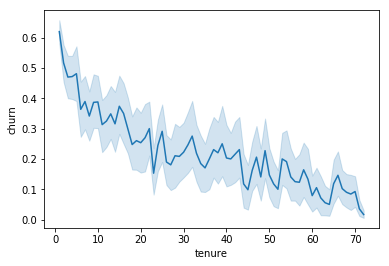

In [11]:
# #1: could month in which a customer signed up influence churn?
# consider this plot: 
sns.lineplot(x='tenure', y='churn', data=df)

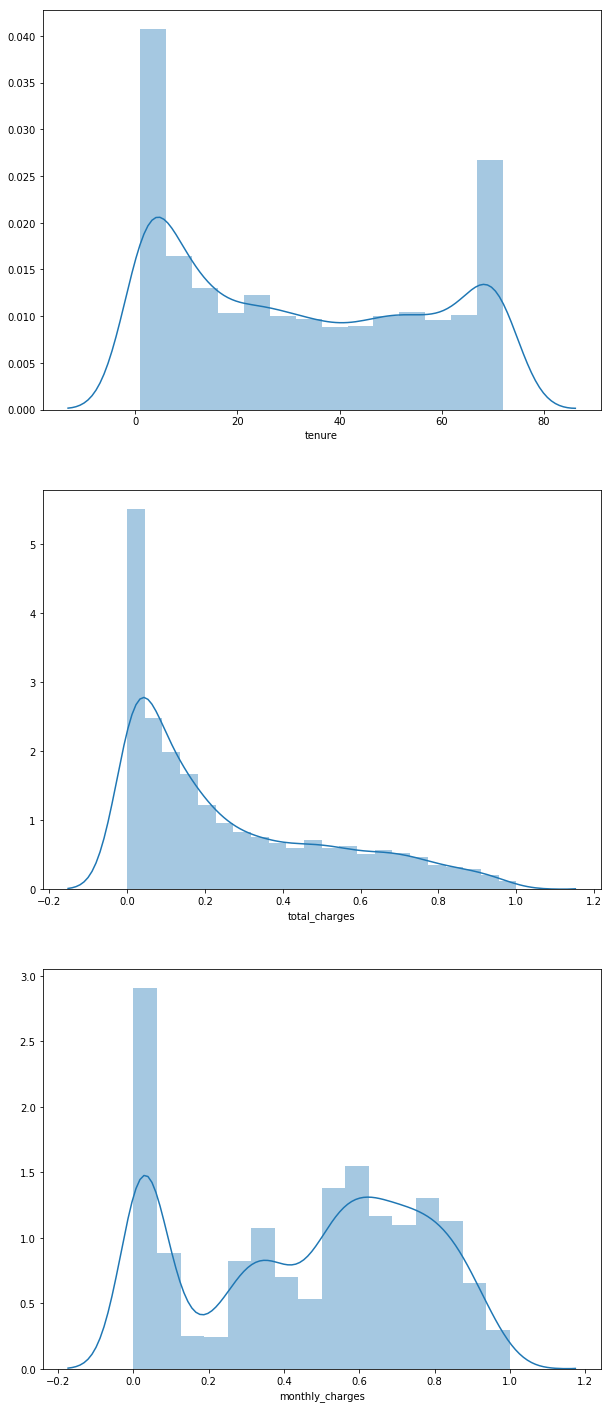

In [12]:
plt.figure(figsize=(10,25))
plt.subplot(3,1,1)
sns.distplot(train['tenure'])
plt.subplot(3,1,2)
sns.distplot(train['total_charges'])
plt.subplot(3,1,3)
sns.distplot(train['monthly_charges'])

#### We can note from this data visualization that there is a downward trend or negative correlation between tenure and attrition.  There are minor spikes that appear to be more correlated with the one year and two year marks than they do with a specific cohort, which overall is roughly consistent.  

### Let's investigate whether certain features indicate higher propensity to churn:

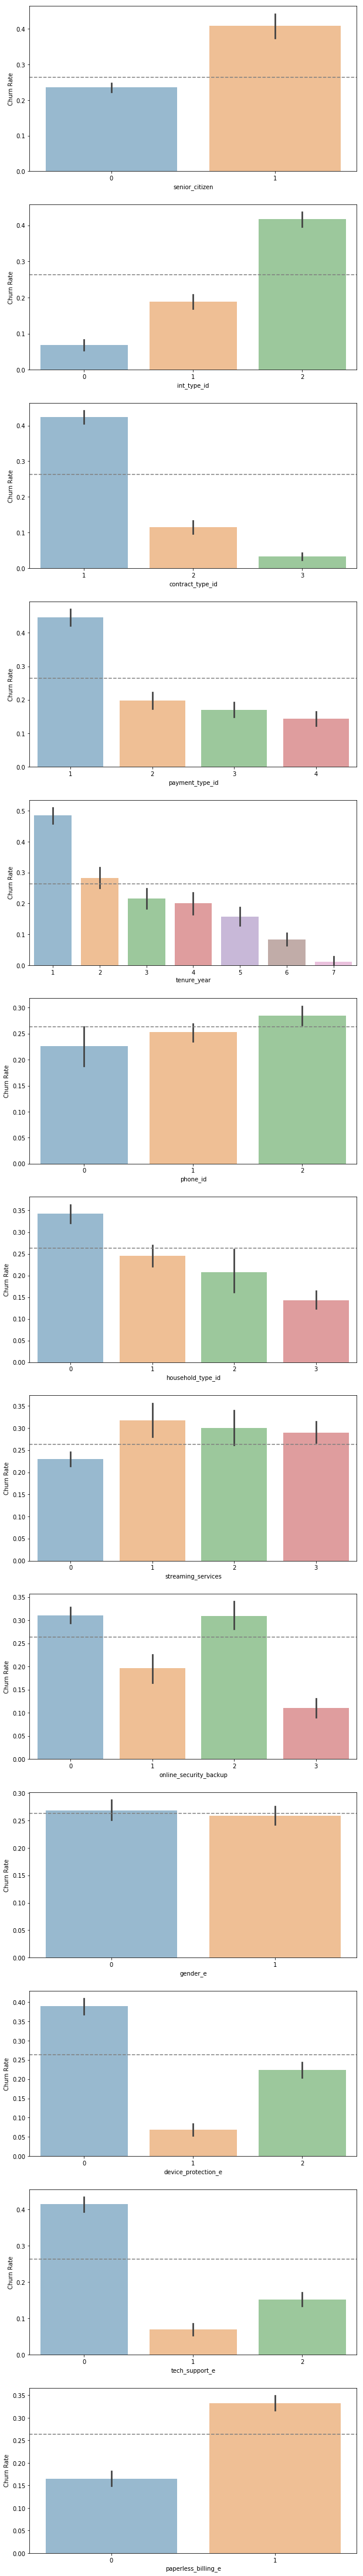

In [13]:
# Visualize our features with bar plots to view average churn rate:
features = ['senior_citizen','int_type_id','contract_type_id','payment_type_id', 'tenure_year', 'phone_id', 'household_type_id', 'streaming_services', 'online_security_backup','gender_e', 'device_protection_e', 'tech_support_e', 'paperless_billing_e']

_, ax = plt.subplots(nrows=13, ncols=1, figsize=(10,80))

churn_rate = train.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

#### From these visualizations, we can see that certain features lead to stronger churning trends.  Off the cuff, we notice that seniors have a stronger tendency to churn, as well as fiber customers and  customers without tech support.  People that have paperless billing churn more on average as well as customers that pay by electronic check, which are intrinsically bound.

In [14]:
#percentage of senior citizens in customers:
train_internet = train.groupby('senior_citizen').count().apply(lambda x: 100* x /float(x.sum()))
train_internet['customer_id']

senior_citizen
0    83.746445
1    16.253555
Name: customer_id, dtype: float64

In [15]:
# percentage of customers by tech support type
train_internet = train.groupby('tech_support_e').count().apply(lambda x: 100* x /float(x.sum()))
train_internet['tenure']

tech_support_e
0    49.248273
1    21.556278
2    29.195449
Name: tenure, dtype: float64

In [16]:
# percentage of customers by device protection services:
train_internet = train.groupby('device_protection_e').count().apply(lambda x: 100* x /float(x.sum()))
train_internet['tenure']

device_protection_e
0    44.087769
1    21.556278
2    34.355953
Name: tenure, dtype: float64

In [17]:
# percentage of customers by internet service type
train_internet = train.groupby('int_type_id').count().apply(lambda x: 100* x /float(x.sum()))
train_internet['tenure']


int_type_id
0    21.556278
1    34.355953
2    44.087769
Name: tenure, dtype: float64

### Let's investigate for price threshholds on specific services.  Propose a few swarm plots of services vs monthly charges: 

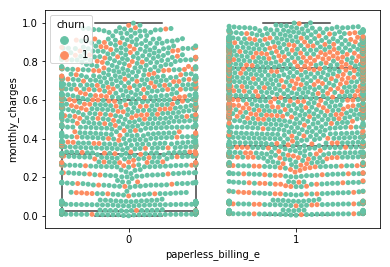

In [18]:
#swarmplot by paperless billing status:
sns.swarmplot(x="paperless_billing_e", y="monthly_charges", data=train, hue="churn", palette="Set2")
ax = sns.boxplot(x="paperless_billing_e", y="monthly_charges", data=train,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})



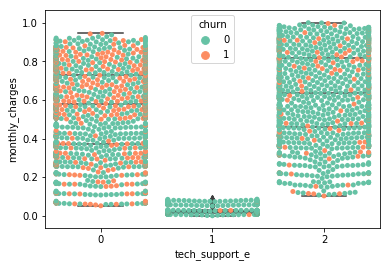

In [19]:
# swarmplot for tech support status: 
sns.swarmplot(x="tech_support_e", y="monthly_charges", data=train, hue="churn", palette="Set2")
ax = sns.boxplot(x="tech_support_e", y="monthly_charges", data=train,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})

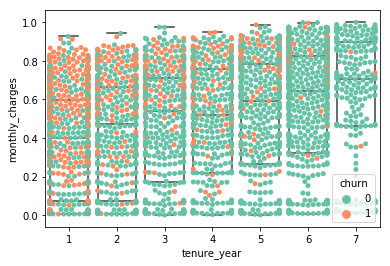

In [20]:
# swarm plot for monthly charges by tenure year
sns.swarmplot(x="tenure_year", y="monthly_charges", data=train, hue="churn", palette="Set2")
ax = sns.boxplot(x="tenure_year", y="monthly_charges", data=train,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})

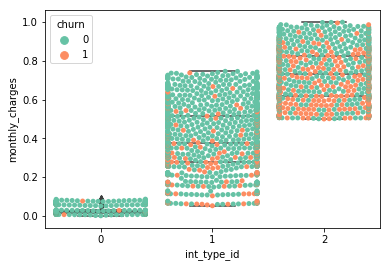

In [21]:
#swarm plot for monthly charges by internet type id
sns.swarmplot(x="int_type_id", y="monthly_charges", data=train, hue="churn", palette="Set2")
ax = sns.boxplot(x="int_type_id", y="monthly_charges", data=train,
        showcaps=True,boxprops={'facecolor':'None'},
        showfliers=True,whiskerprops={'linewidth':0})

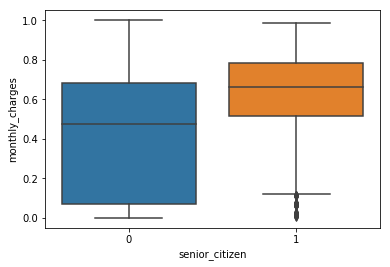

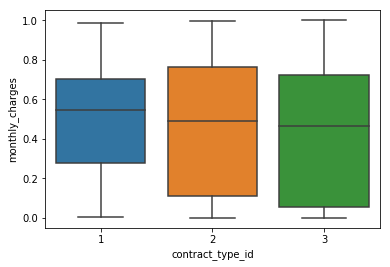

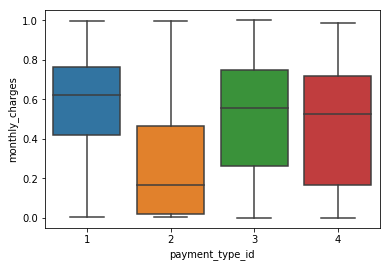

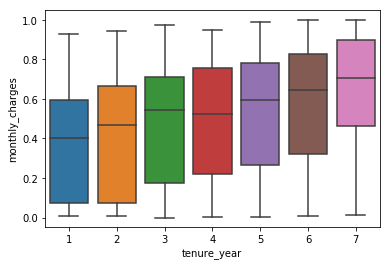

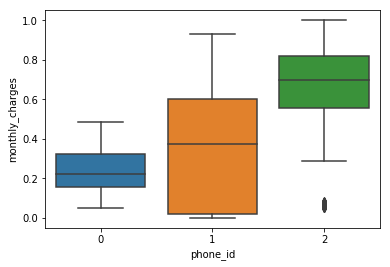

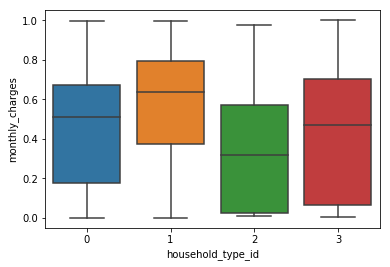

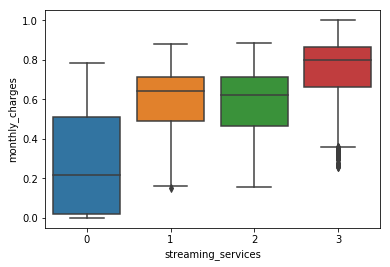

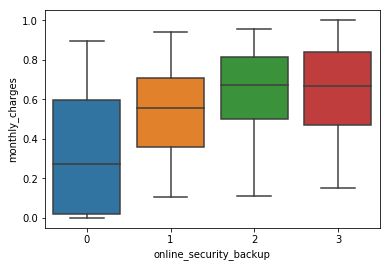

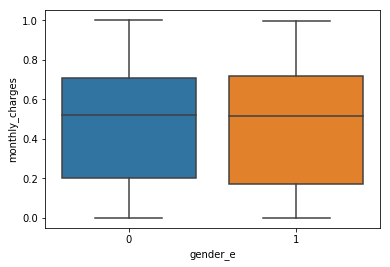

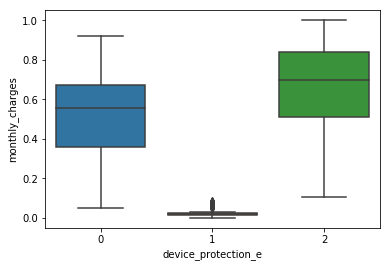

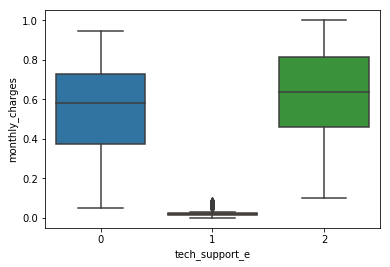

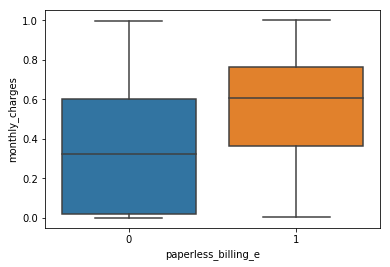

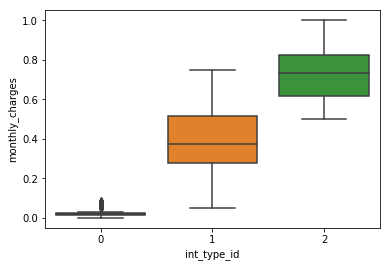

In [47]:
#distribution of monthly charges by categorical data
for col in cols:
    sns.boxplot(x =col, y = 'monthly_charges', data=train)
    plt.show()

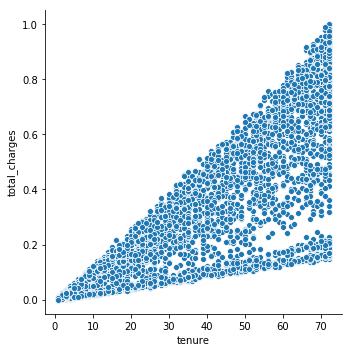

In [23]:
#total charges by tenure scatter
sns.relplot(x = 'tenure', y='total_charges', data=train)

### By a view of these swarm plots we can see that customers are generally weeding out around the 60th percentile.  Let's run a t-test on this.

#### H0: there is no difference in churn between those in the upper 40% of monthly charges vs the lower 60%.
#### Ha: there is a significant difference in churn between these groups.

In [24]:
higher_monthly_charges = train[['churn']][train.monthly_charges > train.monthly_charges.quantile(0.60)]
lower_monthly_charges = train[['churn']][train.monthly_charges < train.monthly_charges.quantile(0.60)]
t_val = ttest(higher_monthly_charges, lower_monthly_charges)
#quick function to test for t-statistic significance and report findings:
def test_t_stat(t_value):
    if (t_val[0] > 1.96 or t_val[0] < 1.96) and t_val[1] < 0.05:
        print(f'Our t-statistic {t_val[0]} is outside of the bounds of |1.96| and is thereby significant. \n Our p-value of {t_val[1]} is less than our alpha 0.05 and is thereby statistically meaningful.\n We can reject the null hypothesis.')
    else:
        print('Our t-test did not reject the null hypothesis')
        
test_t_stat(t_val)

Our t-statistic [10.08294324] is outside of the bounds of |1.96| and is thereby significant. 
 Our p-value of [1.11471325e-23] is less than our alpha 0.05 and is thereby statistically meaningful.
 We can reject the null hypothesis.


### Let's investigate if there is a significant difference in churn rate for those on month-to-month plans after a 12 month period vs those on a year-long contract afte the 12th month.
#### H0: there is not a significant difference in churn after 12 months from month-to-month customers vs those on contracts
#### Ha: there is a significant difference in churn between these groups.

In [25]:
year_old_monthlies = train[train.tenure >= 12][train.contract_type_id == 1]
year_old_monthlies.head()
year_old_contract = train[train.tenure >= 12][train.contract_type_id == 2]
t_val = ttest(year_old_monthlies.churn, year_old_contract.churn)
test_t_stat(t_val)

Our t-statistic 12.0009799705737 is outside of the bounds of |1.96| and is thereby significant. 
 Our p-value of 3.0576000913435556e-32 is less than our alpha 0.05 and is thereby statistically meaningful.
 We can reject the null hypothesis.


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


### Let's investigate if there is a significant difference in monthly charges from our churned customers vs our non-churned customers for any given category of these features.  We will preume for our null hypiothesis that there is no difference in any of these groups.

In [26]:
# create a new column variable list for non-continuous features
cols = ['senior_citizen',
 'contract_type_id',
 'payment_type_id',
 'tenure_year',
 'phone_id',
 'household_type_id',
 'streaming_services',
 'online_security_backup',
 'gender_e',
 'device_protection_e',
 'tech_support_e',
 'paperless_billing_e',
 'int_type_id']
i = 0
# iterate through a loop to run various t-tests
for col in cols:
    i = 0
    for i in range(train[col].min(), train[col].max()+1):
        t_val = ttest(train[(train['churn'] == 1) & (train[col] == i)].monthly_charges, train[(train['churn'] == 0) & (train[col] == i)].monthly_charges)
        print(f'{col} value {i}: \n')
        test_t_stat(t_val)
        print('\n\n')
        

senior_citizen value 0: 

Our t-statistic 12.87870387013588 is outside of the bounds of |1.96| and is thereby significant. 
 Our p-value of 3.0750122184597843e-37 is less than our alpha 0.05 and is thereby statistically meaningful.
 We can reject the null hypothesis.



senior_citizen value 1: 

Our t-test did not reject the null hypothesis



contract_type_id value 1: 

Our t-statistic 11.546574931843702 is outside of the bounds of |1.96| and is thereby significant. 
 Our p-value of 3.902030706117031e-30 is less than our alpha 0.05 and is thereby statistically meaningful.
 We can reject the null hypothesis.



contract_type_id value 2: 

Our t-statistic 8.07948324008887 is outside of the bounds of |1.96| and is thereby significant. 
 Our p-value of 1.797310237136539e-15 is less than our alpha 0.05 and is thereby statistically meaningful.
 We can reject the null hypothesis.



contract_type_id value 3: 

Our t-statistic 4.401303206591712 is outside of the bounds of |1.96| and is thereb

### Our takeaway here: The only t-tests that did not reject the null hypothesis were those customers that were senior citizens, customers in their 7th year of service, and customers that have both online security and backup services.  We cannot say that there is a significant difference in monthly charges in those who churned vs those who did not churn in these groups.  

#### We can posit that in seniors that churn, perhaps price is not a factor as much as something else (perhaps electronic bill pay, which implied a difference in our bar charts from earlier.)

### Let's investigate the correlation between monthly charges and internet service type.  Our swarm plots visually indicated that there was a high proportion of fiber internet customers that churned, and we may compound that with our knowledge that there seems to be a significant difference between monthly bills for those who churned vs those who have not churned.  

In [27]:
#from a dataframe that groups by internet type id
cor_test = train[['monthly_charges', 'int_type_id']]
cor_test.groupby('int_type_id').mean()


,monthly_charges
int_type_id,
0,0.028408
1,0.396413
2,0.728871


Person's correlation between internet service and monthly charges is 0.9049678380220318

p-value is 0.0, less than 0.05.


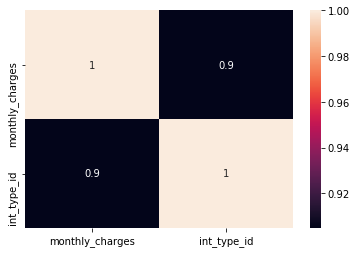

In [28]:
sns.heatmap(cor_test.corr(), annot=True)
print(f'Person\'s correlation between internet service and monthly charges is {pearsonr(cor_test.int_type_id, cor_test.monthly_charges)[0]}\n')
print(f'p-value is {pearsonr(cor_test.int_type_id, cor_test.monthly_charges)[1]}, less than 0.05.')
                                                                                        

In [29]:
#crosstab heatmap to visualize churn rate on internet type id
pd.crosstab(train.int_type_id, train.churn, margins=True).style.background_gradient(cmap='YlOrRd')

churn,0,1,All
int_type_id,,,
0,988,73,1061
1,1372,319,1691
2,1265,905,2170
All,3625,1297,4922


In [30]:
no_int = train[train.int_type_id == 0]
dsl_int = train[train.int_type_id == 1]
fbr_int = train[train.int_type_id == 2]

In [31]:
for i in (no_int, dsl_int, fbr_int):
    print(ttest(i.monthly_charges, i.churn))
    print(pearsonr(i.monthly_charges, i.churn))

Ttest_indResult(statistic=-5.177001827097022, pvalue=2.4676139297919983e-07)
(-0.09356839471023727, 0.002281523372105173)
Ttest_indResult(statistic=20.179619655085517, pvalue=1.3450239632777915e-85)
(-0.2562293222948221, 9.329088662242576e-27)
Ttest_indResult(statistic=28.525826854604208, pvalue=3.4638724937615952e-164)
(-0.22507521826568, 2.5330147676364018e-26)


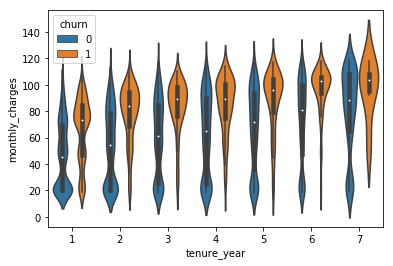

In [32]:
# figure = figsize(18,5)
sns.violinplot(x='tenure_year', y='monthly_charges', hue='churn', data=df)

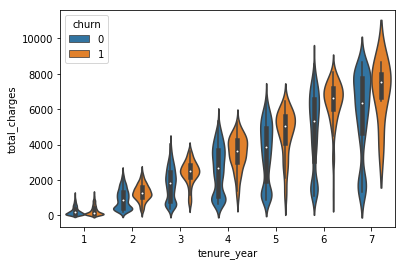

In [33]:
sns.violinplot(x='tenure_year', y='total_charges', hue='churn', data=df)

## ---Pipeline phase 5: Modeling---

### K nearest neighbors model:

In [43]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train.drop(columns='customer_id'), y_train)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [44]:
y_pred = knn.predict(X_train.drop(columns='customer_id'))

y_pred_proba = knn.predict_proba(X_train.drop(columns='customer_id'))

print("accuracy of KNN on training set: {:.2f}".format(knn.score(X_train.drop(columns='customer_id'), y_train)))

accuracy of KNN on training set: 0.84


In [45]:
print(confusion_matrix(y_train, y_pred))

print(classification_report(y_train, y_pred))

cnf = confusion_matrix(y_train, y_pred)

get_confusion_metrics(cnf)

[[3371  254]
 [ 556  741]]
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3625
           1       0.74      0.57      0.65      1297

   micro avg       0.84      0.84      0.84      4922
   macro avg       0.80      0.75      0.77      4922
weighted avg       0.83      0.84      0.83      4922

Recall: [0.92993103 0.57131843]
True Negative Rate: [0.57131843 0.92993103]
Precision: [0.85841609 0.74472362]
Negative Predictive Value: [0.74472362 0.85841609]
False positive Rate: [0.42868157 0.07006897]
False Negative Rate: [0.07006897 0.42868157]
False Discovery Rate: [0.14158391 0.25527638]
Overall Accuracy: [0.83543275 0.83543275]


In [46]:
y_pred_tst = knn.predict(X_test.drop(columns='customer_id'))

y_pred_proba_tst = knn.predict_proba(X_test.drop(columns='customer_id'))

print("accuracy of KNN on training set: {:.2f}".format(knn.score(X_train.drop(columns='customer_id'), y_train)))

accuracy of KNN on training set: 0.84


In [ ]:
y_pred_tst = knn.predict(X_test.drop(columns='customer_id'))

y_pred_proba_tst = knn.predict_proba(X_test.drop(columns='customer_id'))

print("accuracy of KNN on training set: {:.2f}".format(knn.score(X_train.drop(columns='customer_id'), y_train)))

#### The k nearest neighbor model was effective but does not tell us a great amount about contributions of features.  Because it does not do an exceptionally great job telling us about any drivers for churn we will move on from this model.

### Decision Tree Model:

In [48]:
X_t = train[['int_type_id', 'monthly_charges', 'tenure_year', 'payment_type_id']]
y_t = train[['churn']]
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size = 0.30, random_state = 123)

In [49]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=123)

In [50]:
clf.fit(X_train_t, y_train_t)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [51]:
y_pred = clf.predict(X_train_t)
y_pred_proba = clf.predict_proba(X_train_t)

In [52]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train_t, y_train_t)))

Accuracy of Decision Tree classifier on training set: 0.79


In [54]:
c = confusion_matrix(y_train_t, y_pred)
get_confusion_metrics(c)

Recall: [0.90894695 0.44722524]
True Negative Rate: [0.44722524 0.90894695]
Precision: [0.81883024 0.64118565]
Negative Predictive Value: [0.64118565 0.81883024]
False positive Rate: [0.55277476 0.09105305]
False Negative Rate: [0.09105305 0.55277476]
False Discovery Rate: [0.18116976 0.35881435]
Overall Accuracy: [0.78577649 0.78577649]


In [55]:
print(classification_report(y_train_t, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      2526
           1       0.64      0.45      0.53       919

   micro avg       0.79      0.79      0.79      3445
   macro avg       0.73      0.68      0.69      3445
weighted avg       0.77      0.79      0.77      3445



### Performance on this decision tree is fair on our train data, we will continue with a logistic regression

In [56]:
X_train = X_train.drop(columns=(['customer_id', 'gender_e', 'phone_id', 'streaming_services', 'online_security_backup',
                                  'senior_citizen',]))
X_test = X_test.drop(columns=(['customer_id', 'gender_e', 'phone_id', 'streaming_services', 'online_security_backup',
                                  'senior_citizen',]))

In [57]:
logit = LogisticRegression(C=1, class_weight='balanced', random_state=123, solver='newton-cg')

In [58]:
logit.fit(X_train, y_train)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=123,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [59]:
print('Coefficient1: \n', logit.coef_)
print('Intercept1: \n', logit.intercept_)

Coefficient1: 
 [[-7.53380741e-02 -6.99276269e-01 -1.57450687e-01  2.50413102e-03
   2.39529797e-04  3.50316356e-01 -8.27884594e-02 -3.62627785e-03
  -2.28611066e-01  3.40781651e-01  7.61680314e-01]]
Intercept1: 
 [0.62501913]


In [60]:
y_pred = logit.predict(X_train)
y_pred_proba = logit.predict_proba(X_train)

print('Accuracy of Logistic Regression classifier  on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier  on training set: 0.74


In [62]:
print(confusion_matrix(y_train, y_pred))

tpp = confusion_matrix(y_train, y_pred)

print(tpp[1][1] / (tpp[1][1] + tpp[1][0]))
get_confusion_metrics(tpp)

[[2610 1015]
 [ 242 1055]]
0.8134155744024673
Recall: [0.72       0.81341557]
True Negative Rate: [0.81341557 0.72      ]
Precision: [0.91514727 0.50966184]
Negative Predictive Value: [0.50966184 0.91514727]
False positive Rate: [0.18658443 0.28      ]
False Negative Rate: [0.28       0.18658443]
False Discovery Rate: [0.08485273 0.49033816]
Overall Accuracy: [0.74461601 0.74461601]


In [63]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      3625
           1       0.51      0.81      0.63      1297

   micro avg       0.74      0.74      0.74      4922
   macro avg       0.71      0.77      0.72      4922
weighted avg       0.81      0.74      0.76      4922



In [64]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set: 0.73


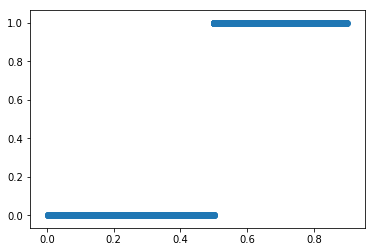

In [65]:
y_pred_proba = [i[1] for i in y_pred_proba]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred_proba, y_pred)

In [67]:
#exporting our predictions based on the logistic model to .csv:
train['predicted'] = logit.predict(X_train)
test['predicted'] = logit.predict(X_test)
train['probability'] = logit.predict_proba(X_train)[:,1]
test['probability'] = logit.predict_proba(X_test)[:,1]
train['customer_id'] = df[['customer_id']]
test['customer_id'] = df[['customer_id']]
df3 = df[['customer_id']]
df3 = train.append(test)
df4 = df3[['customer_id', 'probability', 'predicted']]
df4.to_csv('classification_project.csv')